In [1]:
import locale
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # to suppress pandas warnings about deprecated functions

import pandas as pd
import seaborn as sns

import rangekeeper as rk

In [2]:
locale.setlocale(locale.LC_ALL, 'en_AU')
units = rk.measure.Index.registry
currency = rk.measure.register_currency(registry=units)

In [3]:
iterations = 2000

In [4]:
frequency = rk.duration.Type.YEAR
num_periods = 25
span = rk.span.Span.from_duration(
    name="Span",
    date=pd.Timestamp(2000, 1, 1),
    duration=frequency,
    amount=num_periods)
sequence = span.to_sequence(frequency=frequency)

In [5]:
growth_rate_dist = rk.distribution.Symmetric(
    type=rk.distribution.Type.TRIANGULAR,
    mean=-.0005,
    residual=.005)
initial_value_dist = rk.distribution.Symmetric(
    type=rk.distribution.Type.TRIANGULAR,
    mean=.05,
    residual=.005)

In [6]:
cap_rate = .05

trends = rk.dynamics.trend.Trend.from_likelihoods(
    sequence=sequence,
    cap_rate=cap_rate,
    growth_rate_dist=growth_rate_dist,
    initial_value_dist=initial_value_dist,
    iterations=iterations)

<Axes: ylabel='Count'>

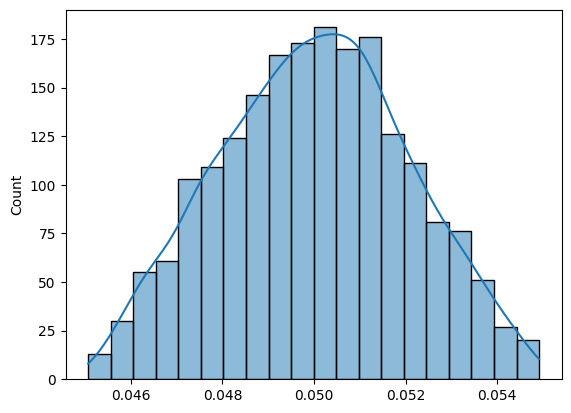

In [7]:
initial_values = [trend.initial_value for trend in trends]
sns.histplot(
    data=initial_values,
    bins=20,
    kde=True)

In [8]:
volatility_per_period = .1
autoregression_param = .2
mean_reversion_param = .3

volatilities = rk.dynamics.volatility.Volatility.from_trends(
    sequence=sequence,
    trends=trends,
    volatility_per_period=volatility_per_period,
    autoregression_param=autoregression_param,
    mean_reversion_param=mean_reversion_param)

In [9]:
space_cycle_phase_prop_dist = rk.distribution.Uniform()

In [10]:
space_cycle_period_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=15,
    residual=5)

In [11]:
space_cycle_height_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=.5,
    residual=0)

In [12]:
asset_cycle_phase_diff_prop_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=0,
    residual=.1)

In [13]:
asset_cycle_period_diff_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=0,
    residual=1)

In [14]:
asset_cycle_amplitude_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=.02,
    residual=0.)

In [15]:
space_cycle_asymmetric_parameter_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=0,
    residual=0.)
asset_cycle_asymmetric_parameter_dist=rk.distribution.Symmetric(
    type=rk.distribution.Type.UNIFORM,
    mean=0,
    residual=0.)

In [16]:
cyclicalities = rk.dynamics.cyclicality.Cyclicality.from_likelihoods(
    sequence=sequence,
    space_cycle_phase_prop_dist=space_cycle_phase_prop_dist,
    space_cycle_period_dist=space_cycle_period_dist,
    space_cycle_height_dist=space_cycle_height_dist,
    asset_cycle_phase_diff_prop_dist=asset_cycle_phase_diff_prop_dist,
    asset_cycle_period_diff_dist=asset_cycle_period_diff_dist,
    asset_cycle_amplitude_dist=asset_cycle_amplitude_dist,
    space_cycle_asymmetric_parameter_dist=space_cycle_asymmetric_parameter_dist,
    asset_cycle_asymmetric_parameter_dist=asset_cycle_asymmetric_parameter_dist,
    iterations=iterations)

In [17]:
noise = rk.dynamics.noise.Noise(
    sequence=sequence,
    noise_dist=rk.distribution.Symmetric(
        type=rk.distribution.Type.TRIANGULAR,
        mean=0.,
        residual=.1))
black_swan = rk.dynamics.black_swan.BlackSwan(
    sequence=sequence,
    likelihood=.05,
    dissipation_rate=mean_reversion_param,
    probability=rk.distribution.Uniform(),
    impact=-.25)

In [18]:
markets = rk.dynamics.market.Market.from_likelihoods(
    sequence=sequence,
    trends=trends,
    volatilities=volatilities,
    cyclicalities=cyclicalities,
    noise=noise,
    black_swan=black_swan)

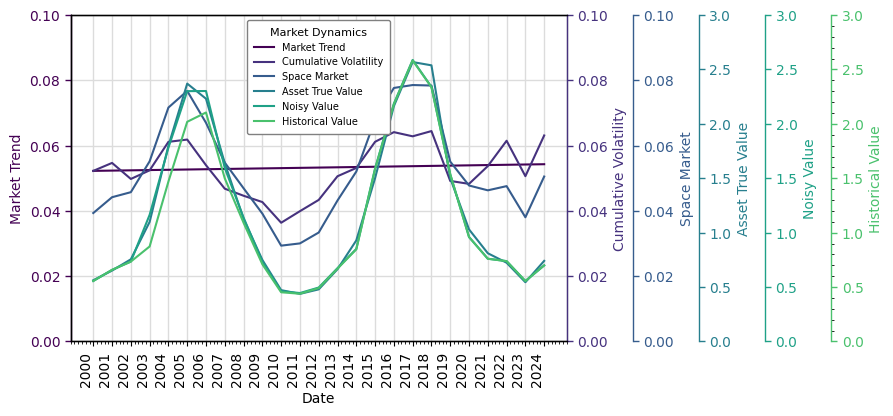

In [19]:
import random
sample_market = markets[random.Random(0).randint(0, iterations - 1)]
table = rk.flux.Stream(
    name='Market Dynamics',
    flows=[
        sample_market.trend,
        sample_market.volatility.volatility,
        sample_market.volatility.autoregressive_returns,
        sample_market.volatility,
        sample_market.cyclicality.space_waveform,
        sample_market.space_market,
        sample_market.cyclicality.asset_waveform,
        sample_market.asset_market,
        sample_market.asset_true_value,
        sample_market.space_market_price_factors,
        sample_market.noisy_value,
        sample_market.historical_value,
        sample_market.implied_rev_cap_rate,
        sample_market.returns
        ],
    frequency=frequency)
table.plot(
        flows={
            'Market Trend': (0, .1),
            'Cumulative Volatility': (0, .1),
            'Space Market': (0, .1),
            'Asset True Value': (0, 3),
            'Noisy Value': (0, 3),
            'Historical Value': (0, 3)
            }
    )

In [20]:
params = {
    'start_date': pd.Timestamp('2001-01-01'),
    'num_periods': 10,
    'frequency': rk.duration.Type.YEAR,
    'acquisition_cost': -1000 * currency.units,
    'initial_income': 100 * currency.units,
    'growth_rate': 0.02,
    'vacancy_rate': 0.05,
    'opex_pgi_ratio': 0.35,
    'capex_pgi_ratio': 0.1,
    'exit_caprate': 0.05,
    'discount_rate': 0.07
    }

In [21]:
class BaseModel:
    def __init__(self) -> None:
        pass
    def set_params(self, params: dict) -> None:
        self.params = params
    def set_market(self, market: rk.dynamics.market.Market) -> None:
        self.market = market
    def init_spans(self):
        self.calc_span = rk.span.Span.from_duration(
            name='Span to Calculate Reversion',
            date=self.params['start_date'],
            duration=self.params['frequency'],
            amount=self.params['num_periods'] + 1)
        self.acq_span = rk.span.Span.from_duration(
            name='Acquisition Span',
            date=rk.duration.offset(
                date=self.params['start_date'],
                amount=-1,
                duration=self.params['frequency']),
            duration=self.params['frequency'])
        self.span = self.calc_span.shift(
            name='Span',
            amount=-1,
            duration=self.params['frequency'])
        self.reversion_span = self.span.shift(
            name='Reversion Span',
            amount=self.params['num_periods'] - 1,
            duration=self.params['frequency'],
            bound='start')
    def calc_acquisition(self):
        self.acquisition = rk.flux.Flow.from_projection(
            name='Acquisition',
            value=self.params['acquisition_cost'],
            proj=rk.projection.Distribution(
                form=rk.distribution.Uniform(),
                sequence=self.acq_span.to_sequence(frequency=self.params['frequency'])),
            units=currency.units)
    def calc_egi(self):
        pgi = rk.flux.Flow.from_projection(
            name='Potential Gross Income',
            value=self.params['initial_income'],
            proj=rk.projection.Extrapolation(
                form=rk.extrapolation.Compounding(
                    rate=self.params['growth_rate']),
                sequence=self.calc_span.to_sequence(frequency=self.params['frequency'])),
            units=currency.units)

        # Construct a Stream that multiplies the Base Model's PGI by the
        # simulated Market's Space Market factors
        self.pgi = (rk.flux.Stream(
            name='Potential Gross Income',
            flows=[
                pgi,
                self.market.space_market_price_factors.trim_to_span(self.calc_span)
                ],
            frequency=self.params['frequency'])
                .product(registry=rk.measure.Index.registry))

        self.vacancy = rk.flux.Flow(
            name='Vacancy Allowance',
            movements=self.pgi.movements * -self.params['vacancy_rate'],
            units=currency.units)
        self.egi = (rk.flux.Stream(
            name='Effective Gross Income',
            flows=[self.pgi, self.vacancy],
            frequency=self.params['frequency'])
                .sum())
    def calc_noi(self):
        self.opex = (rk.flux.Flow(
            name='Operating Expenses',
            movements=self.pgi.movements * self.params['opex_pgi_ratio'],
            units=currency.units)
                .invert())
        self.noi = (rk.flux.Stream(
            name='Net Operating Income',
            flows=[self.egi, self.opex],
            frequency=self.params['frequency'])
                .sum())
    def calc_ncf(self):
        self.capex = (rk.flux.Flow(
            name='Capital Expenditures',
            movements=self.pgi.movements * self.params['capex_pgi_ratio'],
            units=currency.units)
                .invert())
        self.net_cf = (rk.flux.Stream(
            name='Net Annual Cashflow',
            flows=[self.noi, self.capex],
            frequency=self.params['frequency'])
                .sum())
    def calc_reversion(self):
            # Construct the Reversions using the simulated Market's Asset Market
            # factors (cap rates):
            self.reversions = (rk.flux.Flow(
                name='Reversions',
                movements=self.net_cf.movements.shift(periods=-1).dropna() /
                          self.market.implied_rev_cap_rate.movements,
                units=currency.units)
                    .trim_to_span(span=self.span))

            self.reversion = self.reversions.trim_to_span(
                span=self.reversion_span,
                name='Reversion')
            self.pbtcfs = rk.flux.Stream(
                name='PBTCFs',
                flows=[
                    self.net_cf.trim_to_span(span=self.span),
                    self.reversions.trim_to_span(span=self.reversion_span)
                    ],
                frequency=self.params['frequency'])
    def calc_metrics(self):
        pvs = []
        irrs = []
        for period in self.net_cf.trim_to_span(span=self.span).movements.index:
            cumulative_net_cf = self.net_cf.trim_to_span(
                span=rk.span.Span(
                    name='Cumulative Net Cashflow Span',
                    start_date=self.params['start_date'],
                    end_date=period))
            reversion = rk.flux.Flow(
                movements=self.reversions.movements.loc[[period]],
                units=currency.units)
            cumulative_net_cf_with_rev = rk.flux.Stream(
                name='Net Cashflow with Reversion',
                flows=[
                    cumulative_net_cf,
                    reversion
                    ],
                frequency=self.params['frequency'])
            pv = cumulative_net_cf_with_rev.sum().pv(
                name='Present Value',
                frequency=self.params['frequency'],
                rate=self.params['discount_rate'])
            pvs.append(pv.collapse().movements)

            incl_acq = rk.flux.Stream(
                name='Net Cashflow with Reversion and Acquisition',
                flows=[cumulative_net_cf_with_rev.sum(), self.acquisition],
                frequency=self.params['frequency'])

            irrs.append(round(incl_acq.sum().xirr(), 4))

        self.pvs = rk.flux.Flow(
            name='Present Values',
            movements=pd.concat(pvs),
            units=currency.units)
        self.irrs = rk.flux.Flow(
            name='Internal Rates of Return',
            movements=pd.Series(irrs, index=self.pvs.movements.index),
            units=None)
    def generate(self):
        self.init_spans()
        self.calc_acquisition()
        self.calc_egi()
        self.calc_noi()
        self.calc_ncf()
        self.calc_reversion()
        self.calc_metrics()

In [22]:
import os
from typing import List
import multiprocess
import pint
pint.set_application_registry(rk.measure.Index.registry)

In [23]:
inflex_scenarios = []
for market in markets:
    scenario = BaseModel()
    scenario.set_params(params.copy())
    scenario.set_market(market)
    inflex_scenarios.append(scenario)

In [24]:
def generate(scenario):
    scenario.generate()
    return scenario
inflex_scenarios = multiprocess.Pool(os.cpu_count()).map(
    generate,
    inflex_scenarios)

In [25]:
def exceed_pricing_factor(state: rk.flux.Flow) -> List[bool]:
    threshold = 1.2
    result = []
    for i in range(state.movements.index.size):
        if any(result):
            result.append(False)
        else:
            if i < 1:
                result.append(False)
            else:
                if state.movements.iloc[i] > threshold:
                    result.append(True)
                else:
                    result.append(False)
    return result

def adjust_hold_period(
        model: object,
        decisions: List[bool]) -> object:
    # Get the index of the decision flag:
    try:
        idx = decisions.index(True)
    except ValueError:
        idx = len(decisions)

    # Adjust the Model's holding period:
    policy_params = model.params.copy()
    policy_params['num_periods'] = idx

    # Re-run the Model with updated params:
    model.set_params(policy_params)
    model.generate()
    return model

stop_gain_resale_policy = rk.policy.Policy(
    condition=exceed_pricing_factor,
    action=adjust_hold_period)

In [26]:
policy_args = [(scenario.market.space_market_price_factors, scenario) for scenario in inflex_scenarios]
flex_scenarios = multiprocess.Pool(os.cpu_count()).map(
    stop_gain_resale_policy.execute,
    policy_args)

In [27]:
import scipy.stats as ss

In [28]:
inflex_pvs = pd.Series([scenario.pvs.movements.iloc[-1] for scenario in inflex_scenarios])
flex_pvs = pd.Series([scenario.pvs.movements.iloc[-1] for scenario in flex_scenarios])
diff_pvs = flex_pvs - inflex_pvs

pvs = pd.DataFrame({
    'Inflexible': inflex_pvs,
    'Flexible': flex_pvs,
    'Difference': diff_pvs})
pvs.describe()

,Inflexible,Flexible,Difference
count,2000.000000,2000.000000,2000.000000
mean,1077.276022,1471.823622,394.547600
std,346.825710,409.756527,571.287343
min,529.877313,519.892437,-1196.914766
25%,798.547972,1220.486400,-7.520586
50%,979.035364,1487.301431,388.425044
75%,1315.903294,1755.160225,829.231786
max,2358.785044,2445.322698,1750.762120


In [29]:
pvs.skew()

Inflexible    0.828175
Flexible     -0.281891
Difference   -0.077777
dtype: float64

In [30]:
pvs.kurtosis()

Inflexible    0.039147
Flexible     -0.146919
Difference   -0.658811
dtype: float64

In [31]:
print('PV Diffs t-stat: \n{}'.format(
    ss.ttest_1samp(diff_pvs, 0)))

PV Diffs t-stat: 
TtestResult(statistic=30.885867334080228, pvalue=1.379607479805352e-171, df=1999)


<Axes: ylabel='Count'>

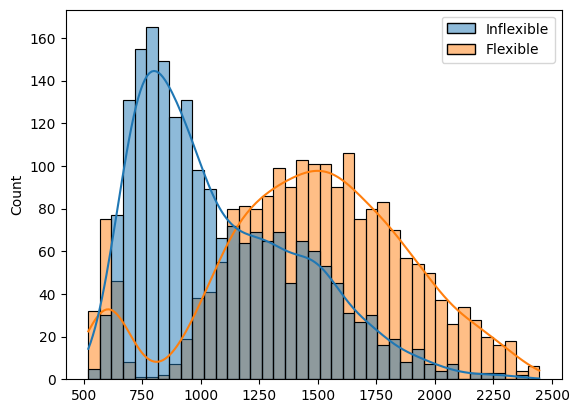

In [32]:
sns.histplot(
    data=pvs.drop(columns=['Difference']),
    binwidth=50,
    kde=True
    )

<Axes: ylabel='Proportion'>

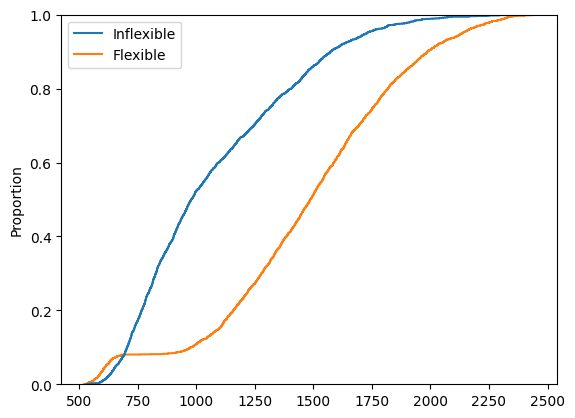

In [33]:
sns.ecdfplot(
    data=pvs.drop(columns=['Difference']))

In [34]:
inflex_irrs = pd.Series([scenario.irrs.movements.iloc[-1] for scenario in inflex_scenarios])
flex_irrs = pd.Series([scenario.irrs.movements.iloc[-1] for scenario in flex_scenarios])
diff_irrs = flex_irrs - inflex_irrs

irrs = pd.DataFrame({
    'Inflexible': inflex_irrs,
    'Flexible': flex_irrs,
    'Difference': diff_irrs})
irrs.describe()

,Inflexible,Flexible,Difference
count,2000.000000,2000.00000,2000.000000
mean,0.071688,0.30250,0.230812
std,0.040480,0.36309,0.376362
min,-0.018500,-0.04190,-0.171800
25%,0.038900,0.09465,0.002300
50%,0.067350,0.13920,0.059350
75%,0.104975,0.31485,0.270175
max,0.177400,1.61650,1.599500


In [35]:
irrs.skew()

Inflexible    0.202274
Flexible      1.879735
Difference    1.807136
dtype: float64

In [36]:
irrs.kurtosis()

Inflexible   -0.889110
Flexible      2.462491
Difference    2.229461
dtype: float64

In [37]:
print('IRR Diffs t-stat: \n{}'.format(
    ss.ttest_1samp(diff_irrs, 0)))

IRR Diffs t-stat: 
TtestResult(statistic=27.42634134595045, pvalue=7.795094497078348e-141, df=1999)


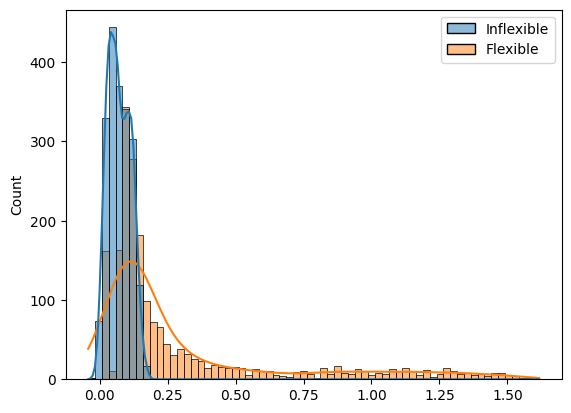

In [38]:
g = sns.histplot(
    data=irrs.drop(columns=['Difference']),
    binwidth=.025,
    kde=True
    )

<Axes: ylabel='Proportion'>

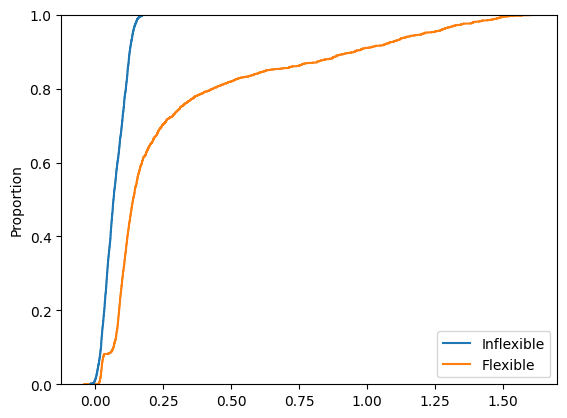

In [39]:
sns.ecdfplot(
    data=irrs.drop(columns=['Difference']))

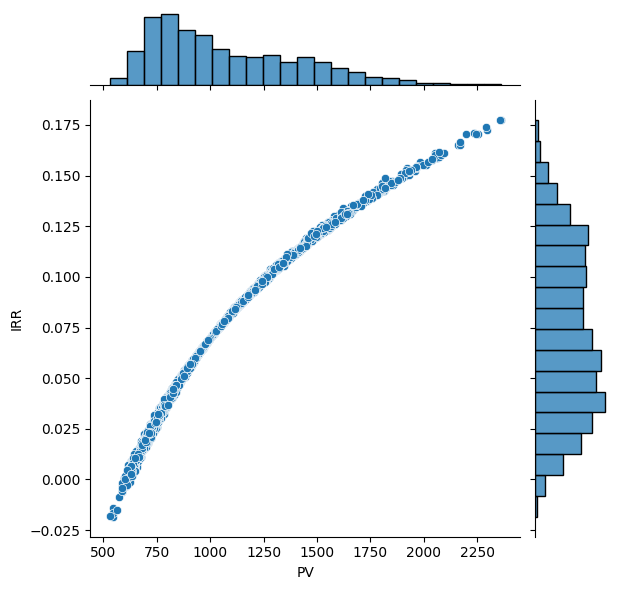

In [40]:
inflex_irr_x_pv = pd.DataFrame({
    'PV': inflex_pvs,
    'IRR': inflex_irrs,})
sns.jointplot(
    data=inflex_irr_x_pv,
    x='PV',
    y='IRR',
    kind='scatter')

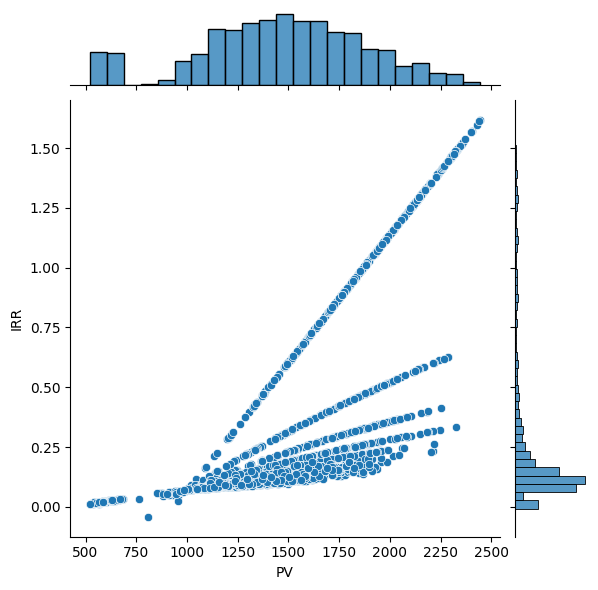

In [41]:
flex_irr_x_pv = pd.DataFrame({
    'PV': flex_pvs,
    'IRR': flex_irrs})
sns.jointplot(
    data=flex_irr_x_pv,
    x='PV',
    y='IRR',
    kind='scatter')

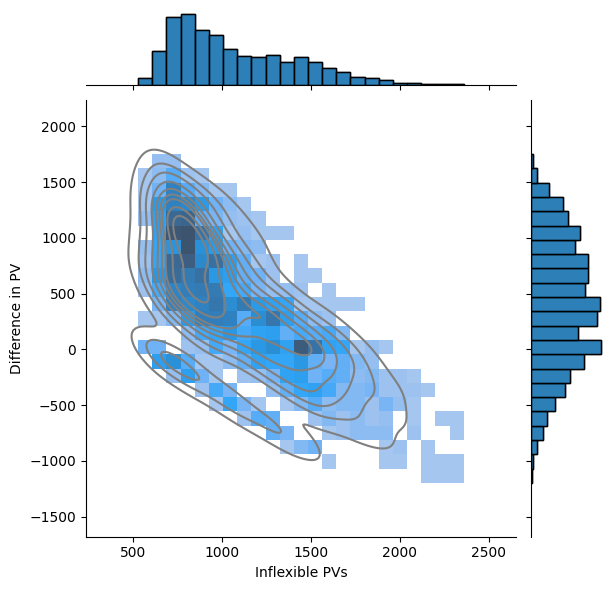

In [42]:
diff_pvs_x_inflex_pvs = pd.DataFrame({
    'Inflexible PVs': inflex_pvs,
    'Difference in PV': diff_pvs})
g = sns.jointplot(
    data=diff_pvs_x_inflex_pvs,
    x='Inflexible PVs',
    y='Difference in PV',
    kind='hist')
g.plot_joint(
    sns.kdeplot,
    color='grey',
    zorder=1,
    levels=10)
g.plot_marginals(
    sns.histplot
    )

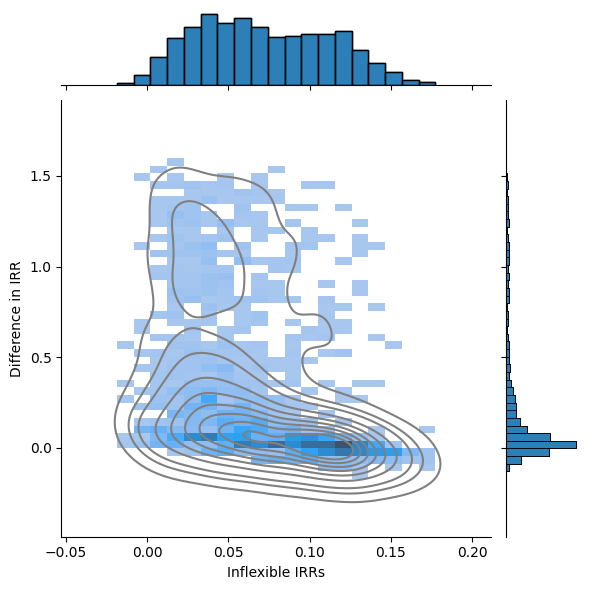

In [43]:
diff_irrs_x_inflex_irrs = pd.DataFrame({
    'Inflexible IRRs': inflex_irrs,
    'Difference in IRR': diff_irrs})
g = sns.jointplot(
    data=diff_irrs_x_inflex_irrs,
    x='Inflexible IRRs',
    y='Difference in IRR',
    kind='hist')
g.plot_joint(
    sns.kdeplot,
    color='grey',
    zorder=1,
    levels=10)
g.plot_marginals(
    sns.histplot
    )